In [ ]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from pygam import LogisticGAM, s, f
from pygam.terms import TermList

warnings.filterwarnings("ignore")

In [3]:
np.random.seed(42)

In [4]:
# Load the data
df = pd.read_csv("./Motor vehicle insurance data.csv", sep=";")
print(df.shape)
df.head()

(105555, 30)


,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,1,05/11/2015,05/11/2015,05/11/2016,15/04/1956,20/03/1976,0,4,1,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
1,1,05/11/2015,05/11/2016,05/11/2017,15/04/1956,20/03/1976,0,4,1,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
2,1,05/11/2015,05/11/2017,05/11/2018,15/04/1956,20/03/1976,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
3,1,05/11/2015,05/11/2018,05/11/2019,15/04/1956,20/03/1976,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
4,2,26/09/2017,26/09/2017,26/09/2018,15/04/1956,20/03/1976,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190


## Feature engineering

In [5]:
# Convert date columns to datetime
date_columns = [col for col in df.columns if "Date" in col]
for col in date_columns:
    if df[col].dtype == "object":
        df[col] = pd.to_datetime(df[col], format="%d/%m/%Y", errors="coerce")

In [ ]:
# Create age features
df["Is_lapse"] = np.where(df["Lapse"] > 0, 1, 0)
df["Age"] = (df["Date_next_renewal"] - df["Date_birth"]).dt.days // 365
df["yoe"] = (df["Date_next_renewal"] - df["Date_driving_licence"]).dt.days // 365
df["contract_duration"] = (
    df["Date_last_renewal"] - df["Date_start_contract"]
).dt.days // 365

In [8]:
final_columns = [
    "Distribution_channel",
    "Seniority",
    "Policies_in_force",
    "Max_products",
    "Payment",
    "Premium",
    "Cost_claims_year",
    "N_claims_year",
    "N_claims_history",
    "R_Claims_history",
    "Type_risk",
    "Area",
    "Second_driver",
    "Value_vehicle",
    "N_doors",
    "yoe",
    "contract_duration",
    "Is_lapse",
]
numeric_cols = [
    "Seniority",
    "Policies_in_force",
    "Max_products",
    "Premium",
    "Cost_claims_year",
    "N_claims_year",
    "N_claims_history",
    "R_Claims_history",
    "Value_vehicle",
    "N_doors",
    "yoe",
    "contract_duration",
]
categorical_cols = [
    "Distribution_channel",
    "Payment",
    "Type_risk",
    "Area",
    "Second_driver",
]
dependent_cols = ["Is_lapse"]

In [9]:
data = df[final_columns]
# Change a data type of categorical features
data[categorical_cols] = data[categorical_cols].astype(object)
data[dependent_cols] = data[dependent_cols].astype(object)

In [10]:
data.isnull().sum()

Distribution_channel    0
Seniority               0
Policies_in_force       0
Max_products            0
Payment                 0
Premium                 0
Cost_claims_year        0
N_claims_year           0
N_claims_history        0
R_Claims_history        0
Type_risk               0
Area                    0
Second_driver           0
Value_vehicle           0
N_doors                 0
yoe                     0
contract_duration       0
Is_lapse                0
dtype: int64

## Modelling

- I would focus on your focus is on predicting policy lapse at the policy level.

### GLM

In [31]:
data.shape

(105555, 18)

In [40]:
X_num = data[numeric_cols]
y = data["Is_lapse"].astype(int)

# Data preprocessing
# scaler = StandardScaler()
# X_scaled_num = pd.DataFrame(
#     scaler.fit_transform(X_num), columns=X_num.columns, index=X_num.index
# )
X_cat = pd.get_dummies(data[categorical_cols], drop_first=True)
X_all = pd.concat([X_num, X_cat], axis=1)

In [41]:
X_all.head()
X_all.dtypes

Seniority                   int64
Policies_in_force           int64
Max_products                int64
Premium                   float64
Cost_claims_year          float64
N_claims_year               int64
N_claims_history            int64
R_Claims_history          float64
Value_vehicle             float64
N_doors                     int64
yoe                         int64
contract_duration           int64
Distribution_channel_1       bool
Payment_1                    bool
Type_risk_2                  bool
Type_risk_3                  bool
Type_risk_4                  bool
Area_1                       bool
Second_driver_1              bool
dtype: object

In [42]:
X_all.head()

,Seniority,Policies_in_force,Max_products,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Value_vehicle,N_doors,yoe,contract_duration,Distribution_channel_1,Payment_1,Type_risk_2,Type_risk_3,Type_risk_4,Area_1,Second_driver_1
0,4,1,1,222.52,0.0,0,0,0.0,7068.0,0,40,0,False,False,False,False,False,False,False
1,4,1,1,213.78,0.0,0,0,0.0,7068.0,0,41,1,False,False,False,False,False,False,False
2,4,2,1,214.84,0.0,0,0,0.0,7068.0,0,42,2,False,False,False,False,False,False,False
3,4,2,1,216.99,0.0,0,0,0.0,7068.0,0,43,3,False,False,False,False,False,False,False
4,4,2,1,213.70,0.0,0,0,0.0,7068.0,0,42,0,False,True,False,False,False,False,False


In [43]:
X_sm = sm.add_constant(X_all)

# Fit the GLM model
glm_model = sm.GLM(y.astype(float), X_sm.astype(float), family=sm.families.Binomial())
glm_results = glm_model.fit()

# Print the model summary
print("\nGLM Model Summary:")
glm_results.summary()


GLM Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Is_lapse   No. Observations:               105555
Model:                            GLM   Df Residuals:                   105535
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49515.
Date:                Sun, 23 Mar 2025   Deviance:                       99031.
Time:                        01:44:01   Pearson chi2:                 4.85e+06
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07131
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.2351      0.054    -41.749      0.000      -2.340      -2.130
Seniority                 -0.0854      0.003    -31.476      0.000      -0.091      -0.080
Policies_in_force          0.3878      0.009     43.614      0.000       0.370       0.405
Max_products               0.1639      0.031      5.213      0.000       0.102       0.225
Premium                    0.0012   6.48e-05     19.015      0.000       0.001       0.001
Cost_claims_year       -5.748e-05   1.31e-05     -4.397      0.000   -8.31e-05   -3.19e-05
N_claims_year             -0.4927      0.012    -40.185      0.000      -0.517      -0.469
N_claims_history           0.0533      0.003     19.782      0.000       0.048       0.059
R_Claims_history           0.5692      0.014     40.113      0.000       0.541       0.597
Value_vehicle          -1.461e-05   1.14e-06    -12.864      0.000   -1.68e-05   -1.24e-05
N_doors                   -0.1014      0.009    -10.921      0.000      -0.120      -0.083
yoe                       -0.0042      0.001     -6.113      0.000      -0.005      -0.003
contract_duration          0.0928      0.003     27.334      0.000       0.086       0.099
Distribution_channel_1     0.2471      0.017     14.753      0.000       0.214       0.280
Payment_1                  0.1782      0.018     10.055      0.000       0.143       0.213
Type_risk_2                0.3216      0.058      5.550      0.000       0.208       0.435
Type_risk_3                0.4028      0.054      7.392      0.000       0.296       0.510
Type_risk_4                0.2714      0.111      2.455      0.014       0.055       0.488
Area_1                     0.1055      0.018      5.933      0.000       0.071       0.140
Second_driver_1           -0.2998      0.026    -11.488      0.000      -0.351      -0.249
==========================================================================================
"""

In [ ]:
# Calculate predictions
glm_pred_proba = glm_results.predict(X_sm.astype(float))
glm_pred = (glm_pred_proba > 0.5).astype(int)

# Evaluate GLM model performance
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
)

glm_accuracy = accuracy_score(y.astype(int), glm_pred)
glm_roc_auc = roc_auc_score(y, glm_pred_proba)

print(f"\nGLM Model Accuracy: {glm_accuracy:.4f}")
print(f"GLM Model ROC AUC: {glm_roc_auc:.4f}")
print("\nGLM Classification Report:")
print(classification_report(y, glm_pred))


GLM Model Accuracy: 0.7991
GLM Model ROC AUC: 0.6994

GLM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     84007
           1       0.56      0.08      0.14     21548

    accuracy                           0.80    105555
   macro avg       0.68      0.53      0.51    105555
weighted avg       0.76      0.80      0.73    105555



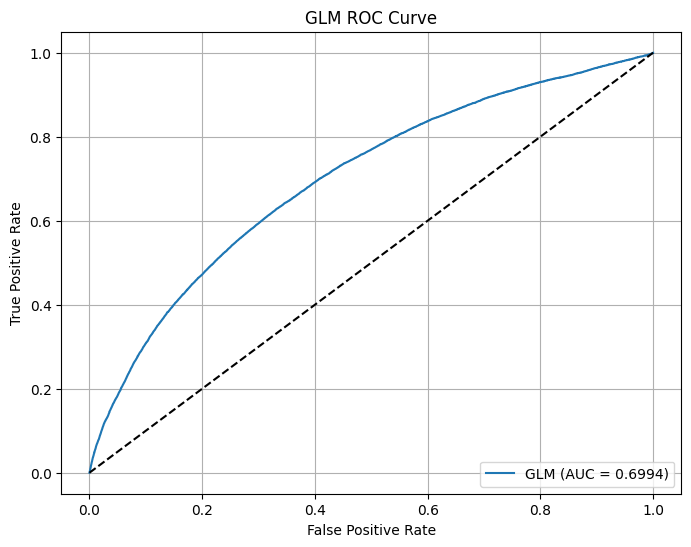

In [16]:
# Plot ROC curve for GLM
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y, glm_pred_proba)
plt.plot(fpr, tpr, label=f"GLM (AUC = {glm_roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GLM ROC Curve")
plt.legend(loc="lower right")
plt.grid()

### GAM

In [ ]:
terms = TermList()
num_count = len(numeric_cols)

for i in range(num_count):
    terms += s(i)  # a spline for each numeric column

for j in range(num_count, X_all.shape[1]):
    terms += f(j)  # each dummy column as a factor

X_array = X_all.values

gam = LogisticGAM(terms).fit(X_array, y)
print(gam.summary())

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    117.8722
Link Function:                        LogitLink Log Likelihood:                                -45785.4164
Number of Samples:                       105555 AIC:                                            91806.5772
                                                AICc:                                           91806.8475
                                                UBRE:                                               2.8706
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1429
Feature Function                  Lam

In [20]:
# Evaluate GAM performance
gam_pred_proba = gam.predict_proba(X_all)
gam_pred = (gam_pred_proba > 0.5).astype(int)

gam_accuracy = accuracy_score(y, gam_pred)
gam_roc_auc = roc_auc_score(y, gam_pred_proba)

print(f"\nGAM Model Accuracy: {gam_accuracy:.4f}")
print(f"GAM Model ROC AUC: {gam_roc_auc:.4f}")
print("\nGAM Classification Report:")
print(classification_report(y, gam_pred))


GAM Model Accuracy: 0.8093
GAM Model ROC AUC: 0.7621

GAM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     84007
           1       0.61      0.19      0.28     21548

    accuracy                           0.81    105555
   macro avg       0.72      0.58      0.59    105555
weighted avg       0.78      0.81      0.77    105555



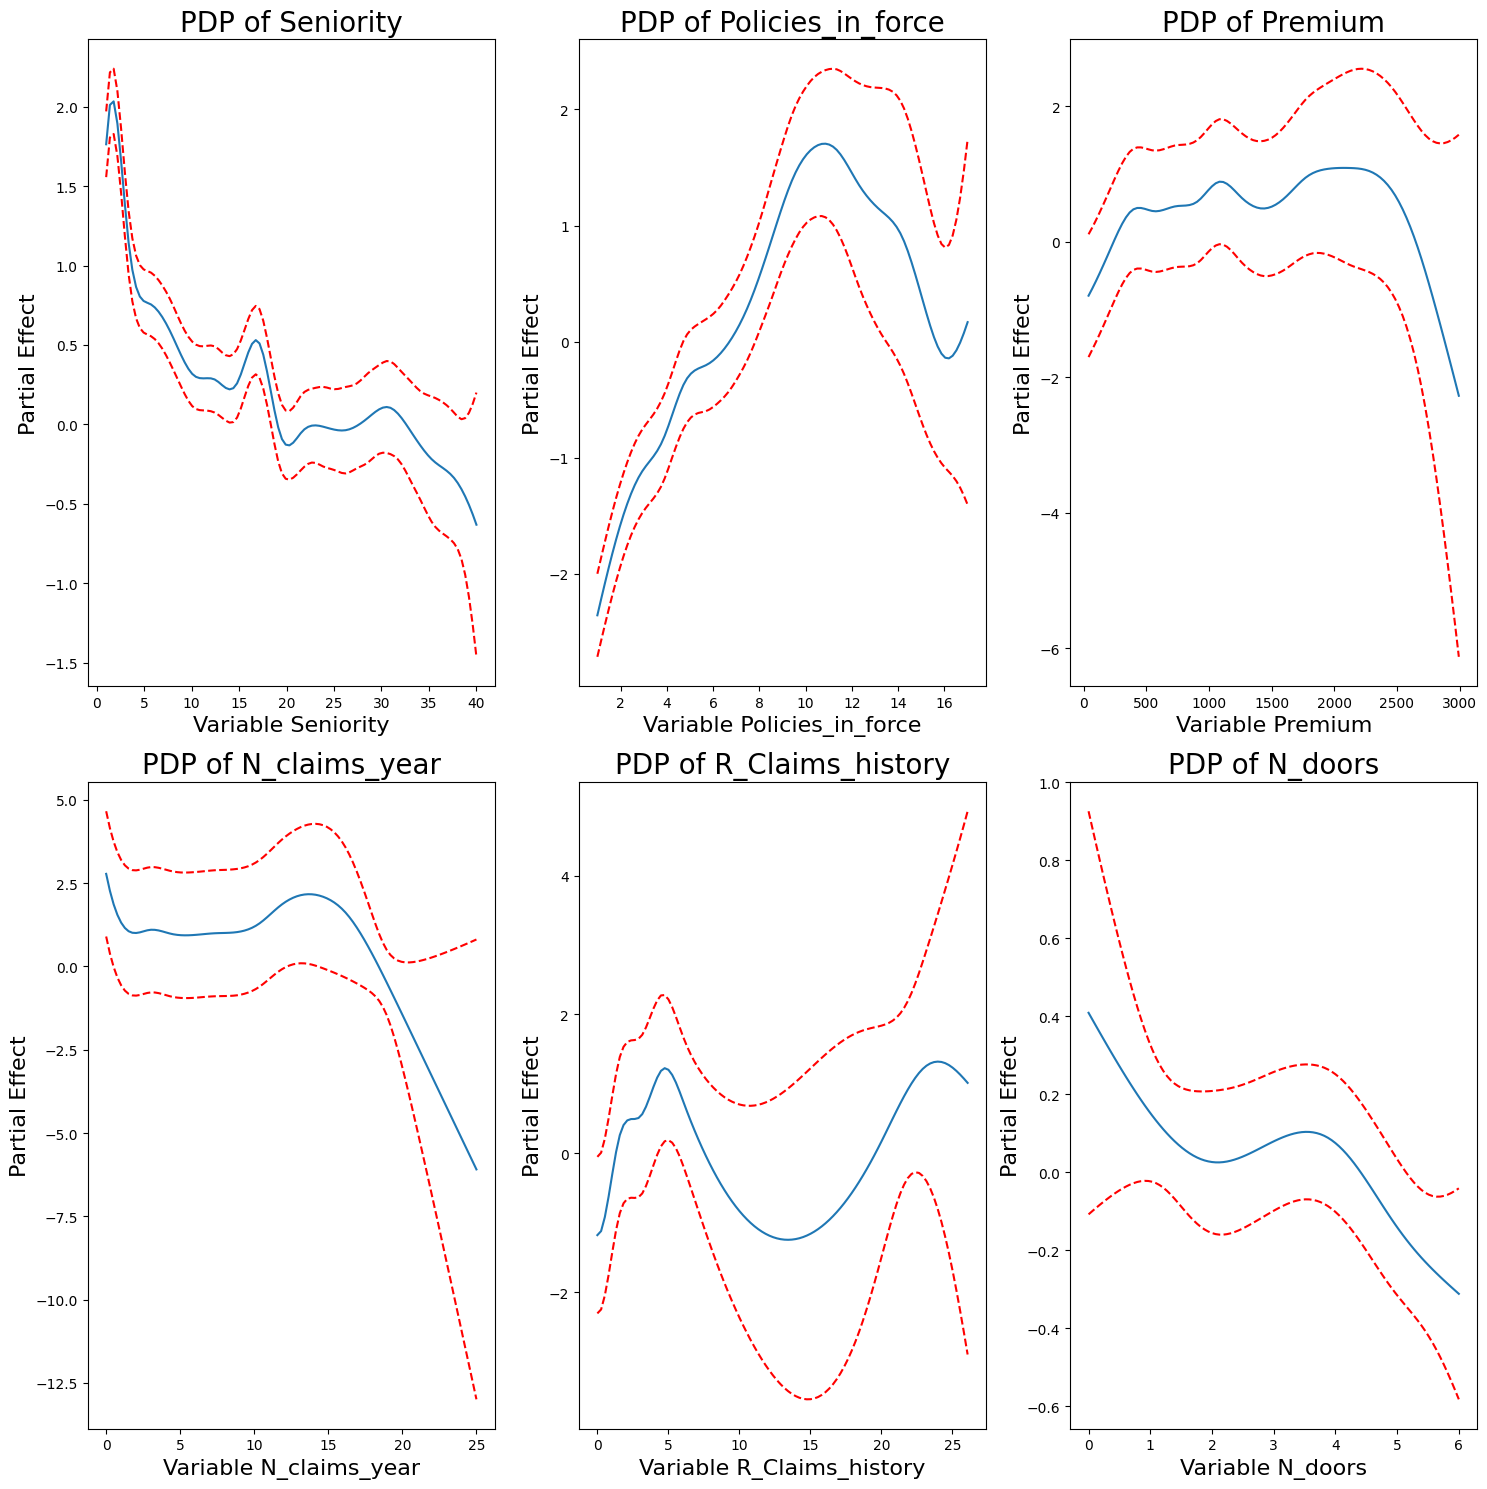

In [ ]:
index = [0, 1, 3, 5, 7, 9]
plot_count = len(index)
rows = 2
cols = 3

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
axs = axs.flatten()

for plot_idx, i in enumerate(index):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    axs[plot_idx].plot(XX[:, i], pdep)
    axs[plot_idx].plot(XX[:, i], confi, c="r", ls="--")
    axs[plot_idx].set_title(f"PDP of {numeric_cols[i]}", fontsize=20)
    axs[plot_idx].set_xlabel(f"Variable {numeric_cols[i]}", fontsize=16)
    axs[plot_idx].set_ylabel("Partial Effect", fontsize=16)

plt.tight_layout()
plt.show()